In [2]:
import numpy as np
from scipy import *
import sys, os
from halotools import sim_manager
import WLanalysis
import h5py
import WLanalysis

In [36]:
######### parameters

RMpc = 2.0 ## Mpc smoothing
Lbox = 512.0 #Mpc/h
Lgrid = 256.0 ## the grid used for computing power spectrum
ibins=arange(Lgrid)
nn=(Lbox/Lgrid)**2
dataset_name='Subsample'

In [6]:
######### subsampled file
subsample_fn = '/Users/jia/neutrino-batch/sample_maps/mnv0.10000_om0.30000_As2.1000/snapshot_066_idmod_101_0.hdf5'
f=h5py.File(subsample_fn,'r')
dataset = f[dataset_name]
particle_pos = dataset['Position']/1e3

In [19]:
############ my previous unsmoothed code
nudir='/Users/jia/Documents/weaklensing/nubias/'
k512,pk512=load(nudir+'kpk_512grid.npy')
k128,pk128=load(nudir+'kpk_128grid.npy')
k256,pk256=load(nudir+'kpk_256grid.npy')

########### full gadget output
kful,pkful=genfromtxt('/Users/jia/neutrino-batch/matterpower/mnv0.10000_om0.30000_As2.1000/powerspec_tot_066.txt').T
knu,pknu=genfromtxt('/Users/jia/neutrino-batch/matterpower/mnv0.10000_om0.30000_As2.1000/powerspec_nu_066.txt').T
fnu=0.1/93.14/0.3/.7**2
pkdm=(sqrt(pkful)-fnu*sqrt(pknu))**2/(1-fnu)**2

########### Marcel's code
ks, pks, Ns = genfromtxt(nudir+'Pk_snapshot_066_idmod_101_0.hdf5_Ng512.txt').T

In [15]:
def gridding (pos):
    grid = histogramdd(pos/Lbox*Lgrid,bins=[ibins,ibins,ibins])[0]
    grid = grid/mean(grid) - 1.0
    return grid

def ps (pos):
    grid = gridding(pos)
    k, ps3d = WLanalysis.PowerSpectrum3D(grid)
    return 2*pi*k/Lbox, ps3d/(Lbox/nn)**3

In [16]:
ktest, pstest = ps(particle_pos)

/Users/jia/Documents/code/CFHTLens_analysis/jia/WLanalysis.py:570: RuntimeWarning: invalid value encountered in divide


In [90]:
igrid = gridding(particle_pos)

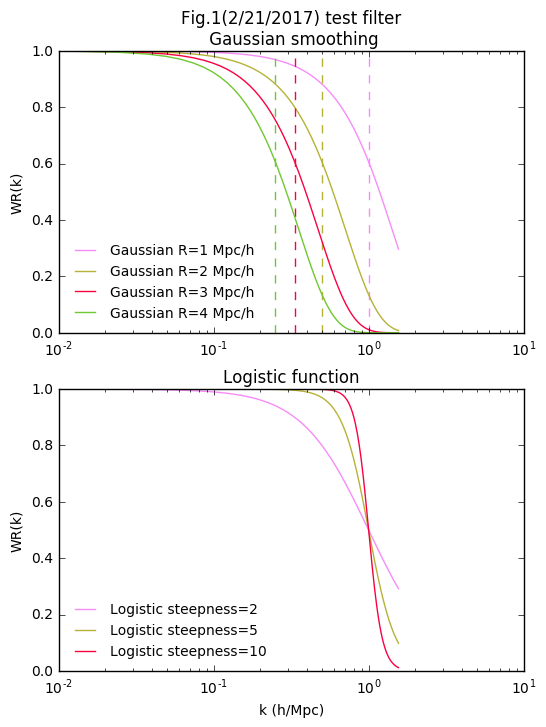

In [87]:
#Rpix=RMpc*Lgrid/Lbox
f=figure(figsize=(6,8))
ax=f.add_subplot(211)
ax2=f.add_subplot(212)
    
seed(4)
for iRMpc in arange(1,5): 
    ik = 1.0/iRMpc
    icolor=rand(3)
    ifreq = arange(Lgrid/2)*2*pi/Lbox
    WR = exp(-(ifreq*iRMpc)**2/2.0)
    ax.plot(ifreq,WR,color=icolor,label='Gaussian R=%i Mpc/h'%(iRMpc))
    ax.plot([ik,ik],[0,1],'--',color=icolor)
seed(4)
for isteep in (2,5,10):
    icolor=rand(3)
    WR = 1-1.0/(1.0+exp(-isteep*log(ifreq)))
    ax2.plot(ifreq,WR,color=icolor,label='Logistic steepness=%i'%(isteep))
    #ax2.plot([0.5,0.5],[0,1],'--',color=icolor)
    
#ax.set_xlabel('k (h/Mpc)')
ax.legend(loc=0,fontsize=10,frameon=0)
ax.set_ylabel('WR(k)')
ax.set_xscale('log')
ax.set_title('Fig.1(2/21/2017) test filter\n Gaussian smoothing')
ax2.set_xlabel('k (h/Mpc)')
ax2.legend(loc=0,fontsize=10,frameon=0)
ax2.set_ylabel('WR(k)')
ax2.set_xscale('log')
ax2.set_title('Logistic function')
show()

In [115]:
def smoothing (grid, isteep=10.0, kcut=1.0):
    kmax=2.0*pi/Lbox*Lgrid/2.0
    grid_fft = fftshift(fftpack.fftn(grid))
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
    if grid.shape[0]%2 == 0:
        center+=0.5
    #d = Lbox/Lgrid
    freq_cube = sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    freq_cube *= 2*pi/Lbox ### since k = k_machine /(d*N), N=Lgrid d=Lbox/Lgrid, d*N=Lbox
    WR = 1-1.0/(1.0+exp(-isteep*log(freq_cube/kcut)))
    WR[freq_cube>=kmax]=0.0 ### cut off at kmax
    #WR = exp(-(2*pi*freq_cube*Rpix)**2/2.0)
    grid_fft *= WR
    return ifftn(ifftshift(grid_fft*WR))

In [125]:
igrid_smooth01 = smoothing(igrid, kcut=0.1)
igrid_smooth1 = smoothing(igrid, kcut=1.0)

In [122]:
igrid_testfft = ifftn(fftn(igrid))

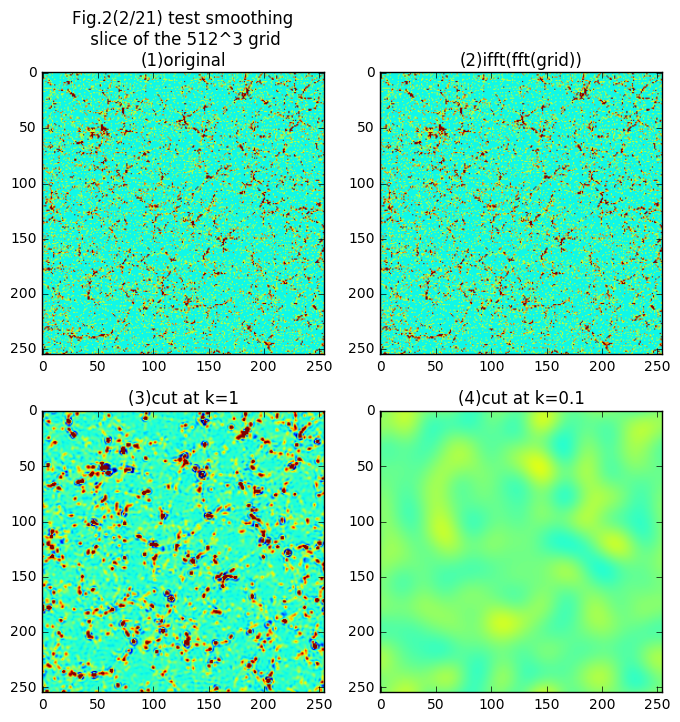

In [140]:
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
istd=std(igrid[100])

cb1=ax1.imshow(igrid[100],vmax=istd, vmin=-istd)
cb2=ax2.imshow(real(igrid_testfft[100]),vmax=istd, vmin=-istd)
cb3=ax3.imshow(real(igrid_smooth1[100]),vmax=istd, vmin=-istd)
cb4=ax4.imshow(real(igrid_smooth01[100]),vmax=istd, vmin=-istd)
ax1.set_title('Fig.2(2/21) test smoothing\n slice of the 512^3 grid\n(1)original')
ax2.set_title('(2)ifft(fft(grid))')
ax3.set_title('(3)cut at k=1')
ax4.set_title('(4)cut at k=0.1')
show()

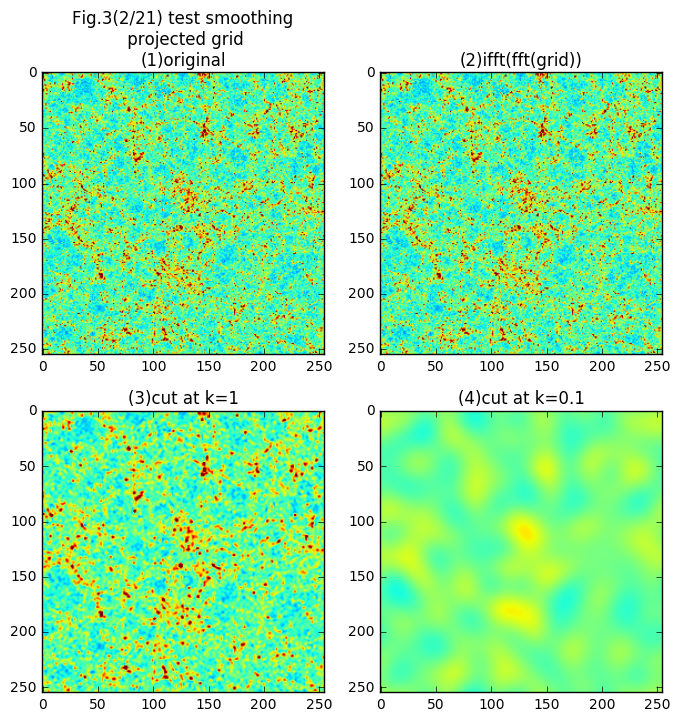

In [138]:
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
istd=std(mean(igrid,axis=0))*3

cb1=ax1.imshow(mean(igrid,axis=0),vmax=istd, vmin=-istd)
cb2=ax2.imshow(mean(real(igrid_testfft),axis=0),vmax=istd, vmin=-istd)
cb3=ax3.imshow(mean(real(igrid_smooth1),axis=0),vmax=istd, vmin=-istd)
cb4=ax4.imshow(mean(real(igrid_smooth01),axis=0),vmax=istd, vmin=-istd)

ax1.set_title('Fig.3(2/21) test smoothing\n projected grid\n(1)original')
ax2.set_title('(2)ifft(fft(grid))')
ax3.set_title('(3)cut at k=1')
ax4.set_title('(4)cut at k=0.1')
show()

In [144]:
ps_smooth1 = WLanalysis.PowerSpectrum3D(real(igrid_smooth1))#/(Lbox/nn)**3
ps_smooth01 = WLanalysis.PowerSpectrum3D(real(igrid_smooth01))#/(Lbox/nn)**3

In [146]:
pss1 = ps_smooth1[1] / (Lbox/nn)**3
pss01 = ps_smooth01[1] / (Lbox/nn)**3

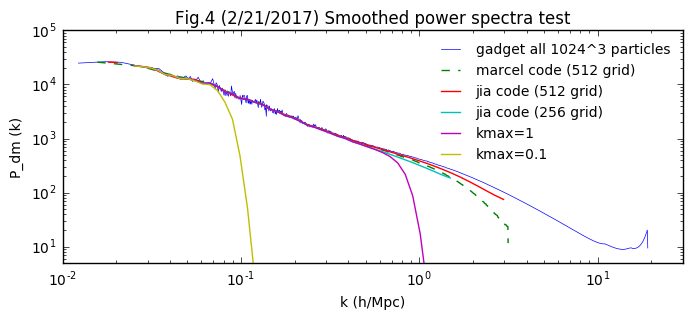

In [148]:
figure(figsize=(8,3))
loglog(kful*1e3,pkdm/1e9,'-',lw=0.5, label='gadget all 1024^3 particles')
loglog(ks,pks,'--', label='marcel code (512 grid)')
loglog(k512,pk512, label='jia code (512 grid)')
loglog(k256,pk256, label='jia code (256 grid)')
loglog(k256,pss1, label='kmax=1')
loglog(k256,pss01, label='kmax=0.1')

#loglog(k128,pk128, label='jia code (128 grid)')
#loglog(ktest,pstest, label='jia code (256 grid test)')
legend(fontsize=10,frameon=0)
title('Fig.4 (2/21/2017) Smoothed power spectra test')
xlim(1e-2,30)
ylim(5,1e5)
xlabel('k (h/Mpc)')
ylabel('P_dm (k)')
show()